### Facial keypoints detection of Ancient Statues

Here is a simple tutorial on detecting facial keypoints of ancient statues.

We will mostly use ancient greek and egyptian statues, but same principals apply to any statue litterally.

We will also observe some of the key points during the detection process.

####  The Packages

The goal of this tutorial is NOT to introduce to the user to cutting edge technology.
Rather we try to show what can be easily applied to get some initial results.

We import packages as the following

In [1]:
# Packages
import os # path manipulations
import cv2 # standard computer vision package in python
import numpy as np # for image matrix manipulations
import matplotlib.pyplot as plt # for visualising images
import glob # for obtaining image paths easily 
 
from keras.models import load_model # for loading trained model
from pandas.io.parsers import read_csv # for loading target data
from sklearn.utils import shuffle # for shuffling the training and test data

Using TensorFlow backend.


Here are couple of functions to facilitate the process.


In [2]:
def load_data(test=False):
    """
    Loads data from test_path if *test* is True, otherwise from train_path.
    Important that the files are in a `data` directory
    Dataset comes from the kaggle:
    https://www.kaggle.com/c/facial-keypoints-detection/data
    code adapted from:
    https://github.com/udacity/AIND-CV-FacialKeypoints/blob/master/utils.py
    """
    train_path = 'data/training.csv'
    test_path = 'data/test.csv'
    fname = test_path if test else train_path
    df = read_csv(os.path.expanduser(fname))  # load dataframes
    # Convert image col values to np ndarray
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    df = df.dropna()
    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32) # convert their type to 32 bit float
    X = X.reshape(-1, 96, 96, 1) 
    # reshape the image matrix into 96x96
    # -1 corresponds to the nb of images in the dataset.
    # since we don't know the exact nb we put -1 and numpy works it out
    # to have the correct number

    if not test:  
        # only training data has target columns
        # test data should not have target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

def plot_data(img, landmarks, axis):
    """
    Plot image (img), along with normalized facial keypoints (landmarks)
    Code taken from:
    https://github.com/udacity/AIND-CV-FacialKeypoints/blob/master/utils.py
    """
    axis.imshow(np.squeeze(img), cmap='gray') # plot the image
    landmarks = landmarks * 48 + 48 # undo the normalization
    # Plot the keypoints
    axis.scatter(landmarks[0::2], # get x coordinates
        landmarks[1::2], # get y coordinates
        marker='o', 
        c='c', 
        s=40)
 
def show_images(images, 
               cols = 1, 
               titles = None,
               cmap="gray",
               title_color="yellow"):
    """Display a list of images in a single figure with matplotlib.
    
    code slightly modified from:
    https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: 
        titles = ['Image {}'.format(str(i))  for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        a.imshow(image, cmap=cmap)
        a.set_title(title, color=title_color)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

Let's see the structure of our dataset

In [3]:
# Load training set
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

# Load testing set
X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (1783, 96, 96, 1)


Basically we have 2140 images in training set each of them is 96x96.

Let's visualize them

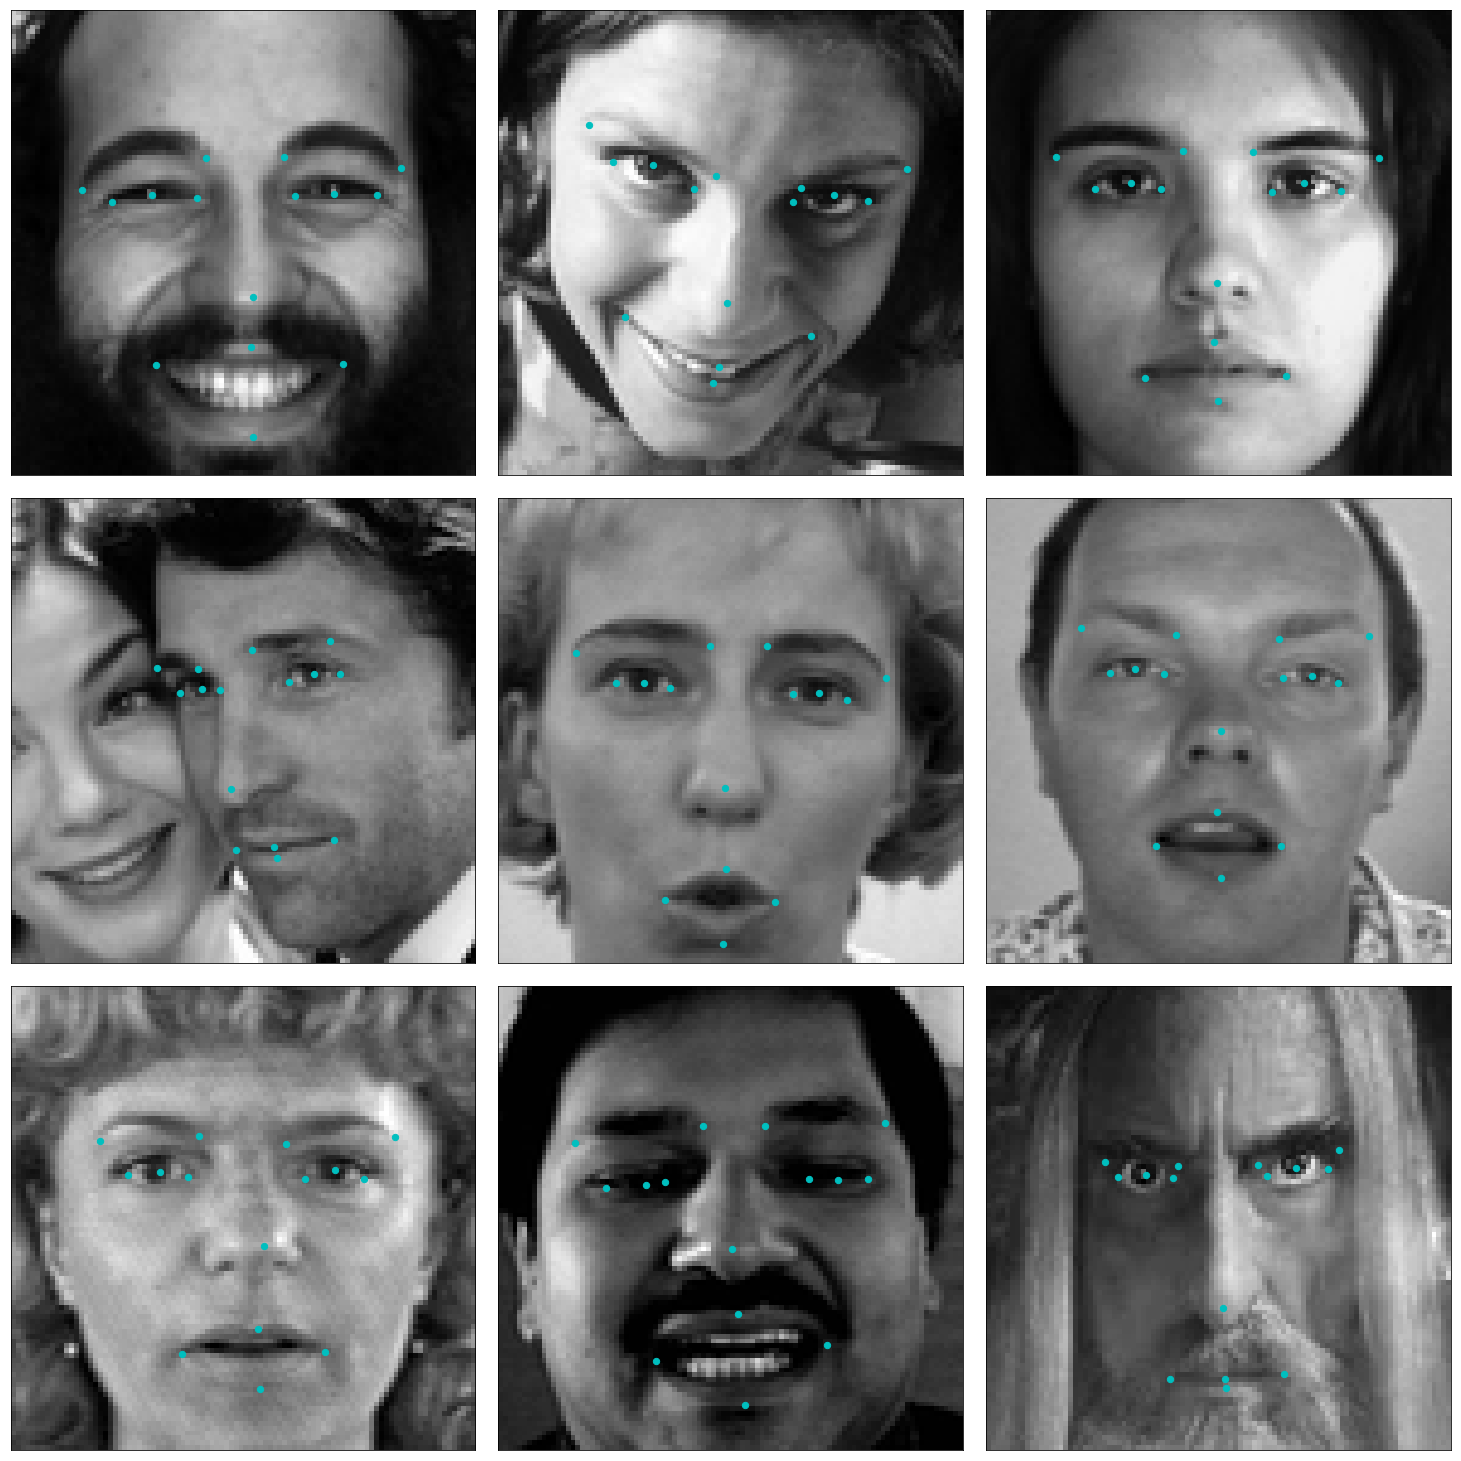

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, 
                    top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_train[i], y_train[i], ax)

Let's construct our pipeline for a single image

no faces:  1


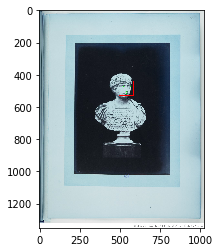

In [5]:
# utils load keypoints
from keras.models import Sequential # loading model type
image = cv2.imread('images/bookStatue2.jpg') # read the image

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert the image to grayscale

# loading the face detector
face_cascade = cv2.CascadeClassifier('detectors/haarcascade_frontalface_default.xml')

# detect faces in the image
faces = face_cascade.detectMultiScale(gray, 
                                      1.25, 
                                      6)

# See if the faces are detected
print("no faces: ", len(faces))

# read model weights
model2 = load_model("lastmodel25.h5") 

# Make a copy of the image for keeping the original unchanged
image_with_detections = image.copy()

# Get the bounding box for each detected face
for i in range(len(faces)):
    x,y,w,h = faces[i]
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, 
                  (x,y), 
                  (x+w,y+h), 
                  (255,0,0), 2)
    # Slice the face section from the original image
    roi = image_with_detections[y:y+h, x:x+w]
    # Get shape of the bounding box of the image
    roi_shape = roi.shape
    # convert to grayscale once again since the 
    # bounding box is red 
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    # Resize the image to conform to the input of our model
    # this is necessary since the image might come in a form that
    # can not be reshaped directly to the form of of the input 
    roi_gray = cv2.resize(roi_gray, (96,96))
    # Reshape the image matrix to conform to the input of our model
    # Map the image pixel values between 0 - 1
    roi_rescale_reshape = roi_gray.reshape(-1, 96, 96, 1) / 255.0
    # Get the predicted coordinates for facial keypoints from the model
    predictions = model2.predict(roi_rescale_reshape)
    # reshape predictions and rescale them
    # This is simply an undo of what we had done during the 
    # loading of the data
    predictions = (np.squeeze(predictions) * 48) + 48
    # Reshape predictions for easy manipulation
    # reshaping them to the following structure
    # [(x,y), (x,y), ...]
    predictions = predictions.reshape((-1,2))
    # Rescale the predictions by using the original shape
    # This is again an undo of what we had done before predicting
    predictions[:,0] = (predictions[:,0]) * roi_shape[0] / 96 # rescale x
    predictions[:,1] = (predictions[:,1]) * roi_shape[1] / 96 # rescale y
    # Change the coordinate values to integer
    # we change it to the list as well, since 
    # iterating over list is faster than iterating
    # over an array
    pred_list = np.int32(predictions).tolist()
    #
    for a,b in pred_list:
        cv2.circle(img=roi, # the image to which we draw
                   center=(a,b), # the coordinate for the center of the circle
                   radius=2, # the radius of the circle
                   color=(0,255,0), # the color of the circle
                  thickness=1) # thickness of the line drawing the circle
        
plt.imshow(image_with_detections) # show the image

Here is a function that wraps the pipeline

In [6]:
def pipeline_keypoints(image, 
                       face_cascade, 
                       model,
                       model_input_shape=96,
                       predictions_shape=48,
                       pointcircle_color=(0,0,255),
                       facebox_color=(255,0,0)
                      ):
    "Wrapping the pipline for image facial keypoints detection"
    image_detect = image.copy()
    imcopy = image.copy()
    imgray = cv2.cvtColor(imcopy, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(imgray, 1.25, 6)
    print("no faces: ", len(faces))
    for i in range(len(faces)):
        x,y,w,h = faces[i]
        # Add a red bounding box to the detections image
        cv2.rectangle(image_detect, 
                      (x,y), 
                      (x+w,y+h), 
                      facebox_color, 2)
        roi = image_detect[y:y+h, x:x+w]
        roi_shape = roi.shape
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) # convert to grayscale
        roi_gray = cv2.resize(roi_gray, (model_input_shape,
                                         model_input_shape))
        roi_rescale_reshape = roi_gray.reshape(-1, 
                                               model_input_shape, 
                                               model_input_shape, 1) / 255.0 # reshape for model input
        predictions = model.predict(roi_rescale_reshape) # get predictions
        # reshape predictions
        predictions = (np.squeeze(predictions) * predictions_shape) + predictions_shape # reshape predictions
        predictions = predictions.reshape((-1,2)) #
        # reshape predictions to [(x,y), (x,y), ...]
        print(predictions.shape)
        predictions[:,0] = (predictions[:,0]) * roi_shape[0] / model_input_shape # rescale x
        predictions[:,1] = (predictions[:,1]) * roi_shape[1] / model_input_shape # rescale y
        
        pred_list = np.int32(predictions).tolist()
        #
        for a,b in pred_list:
            cv2.circle(img=roi,
                       center=(a,b),
                       radius=2,
                       color=(0,255,0),
                      thickness=1)
    #
    return image_detect

Let's apply our function to our list of images

In [7]:
# Reading the images from the path
image_folder = "./images/"
images_paths = glob.glob(image_folder+"*.jpg") # creates a list of paths from the folder
images = [cv2.imread(path) for path in images_paths] # loads the images in the path as ndarray

In [8]:
face_cascade = cv2.CascadeClassifier('detectors/haarcascade_frontalface_default.xml')
detected_images = [pipeline_keypoints(image=image,
                                      face_cascade=face_cascade,
                                      model=model2,
                                     ) for image in images]

no faces:  1
(15, 2)
no faces:  1
(15, 2)
no faces:  0
no faces:  1
(15, 2)
no faces:  0
no faces:  1
(15, 2)
no faces:  1
(15, 2)
no faces:  0
no faces:  1
(15, 2)


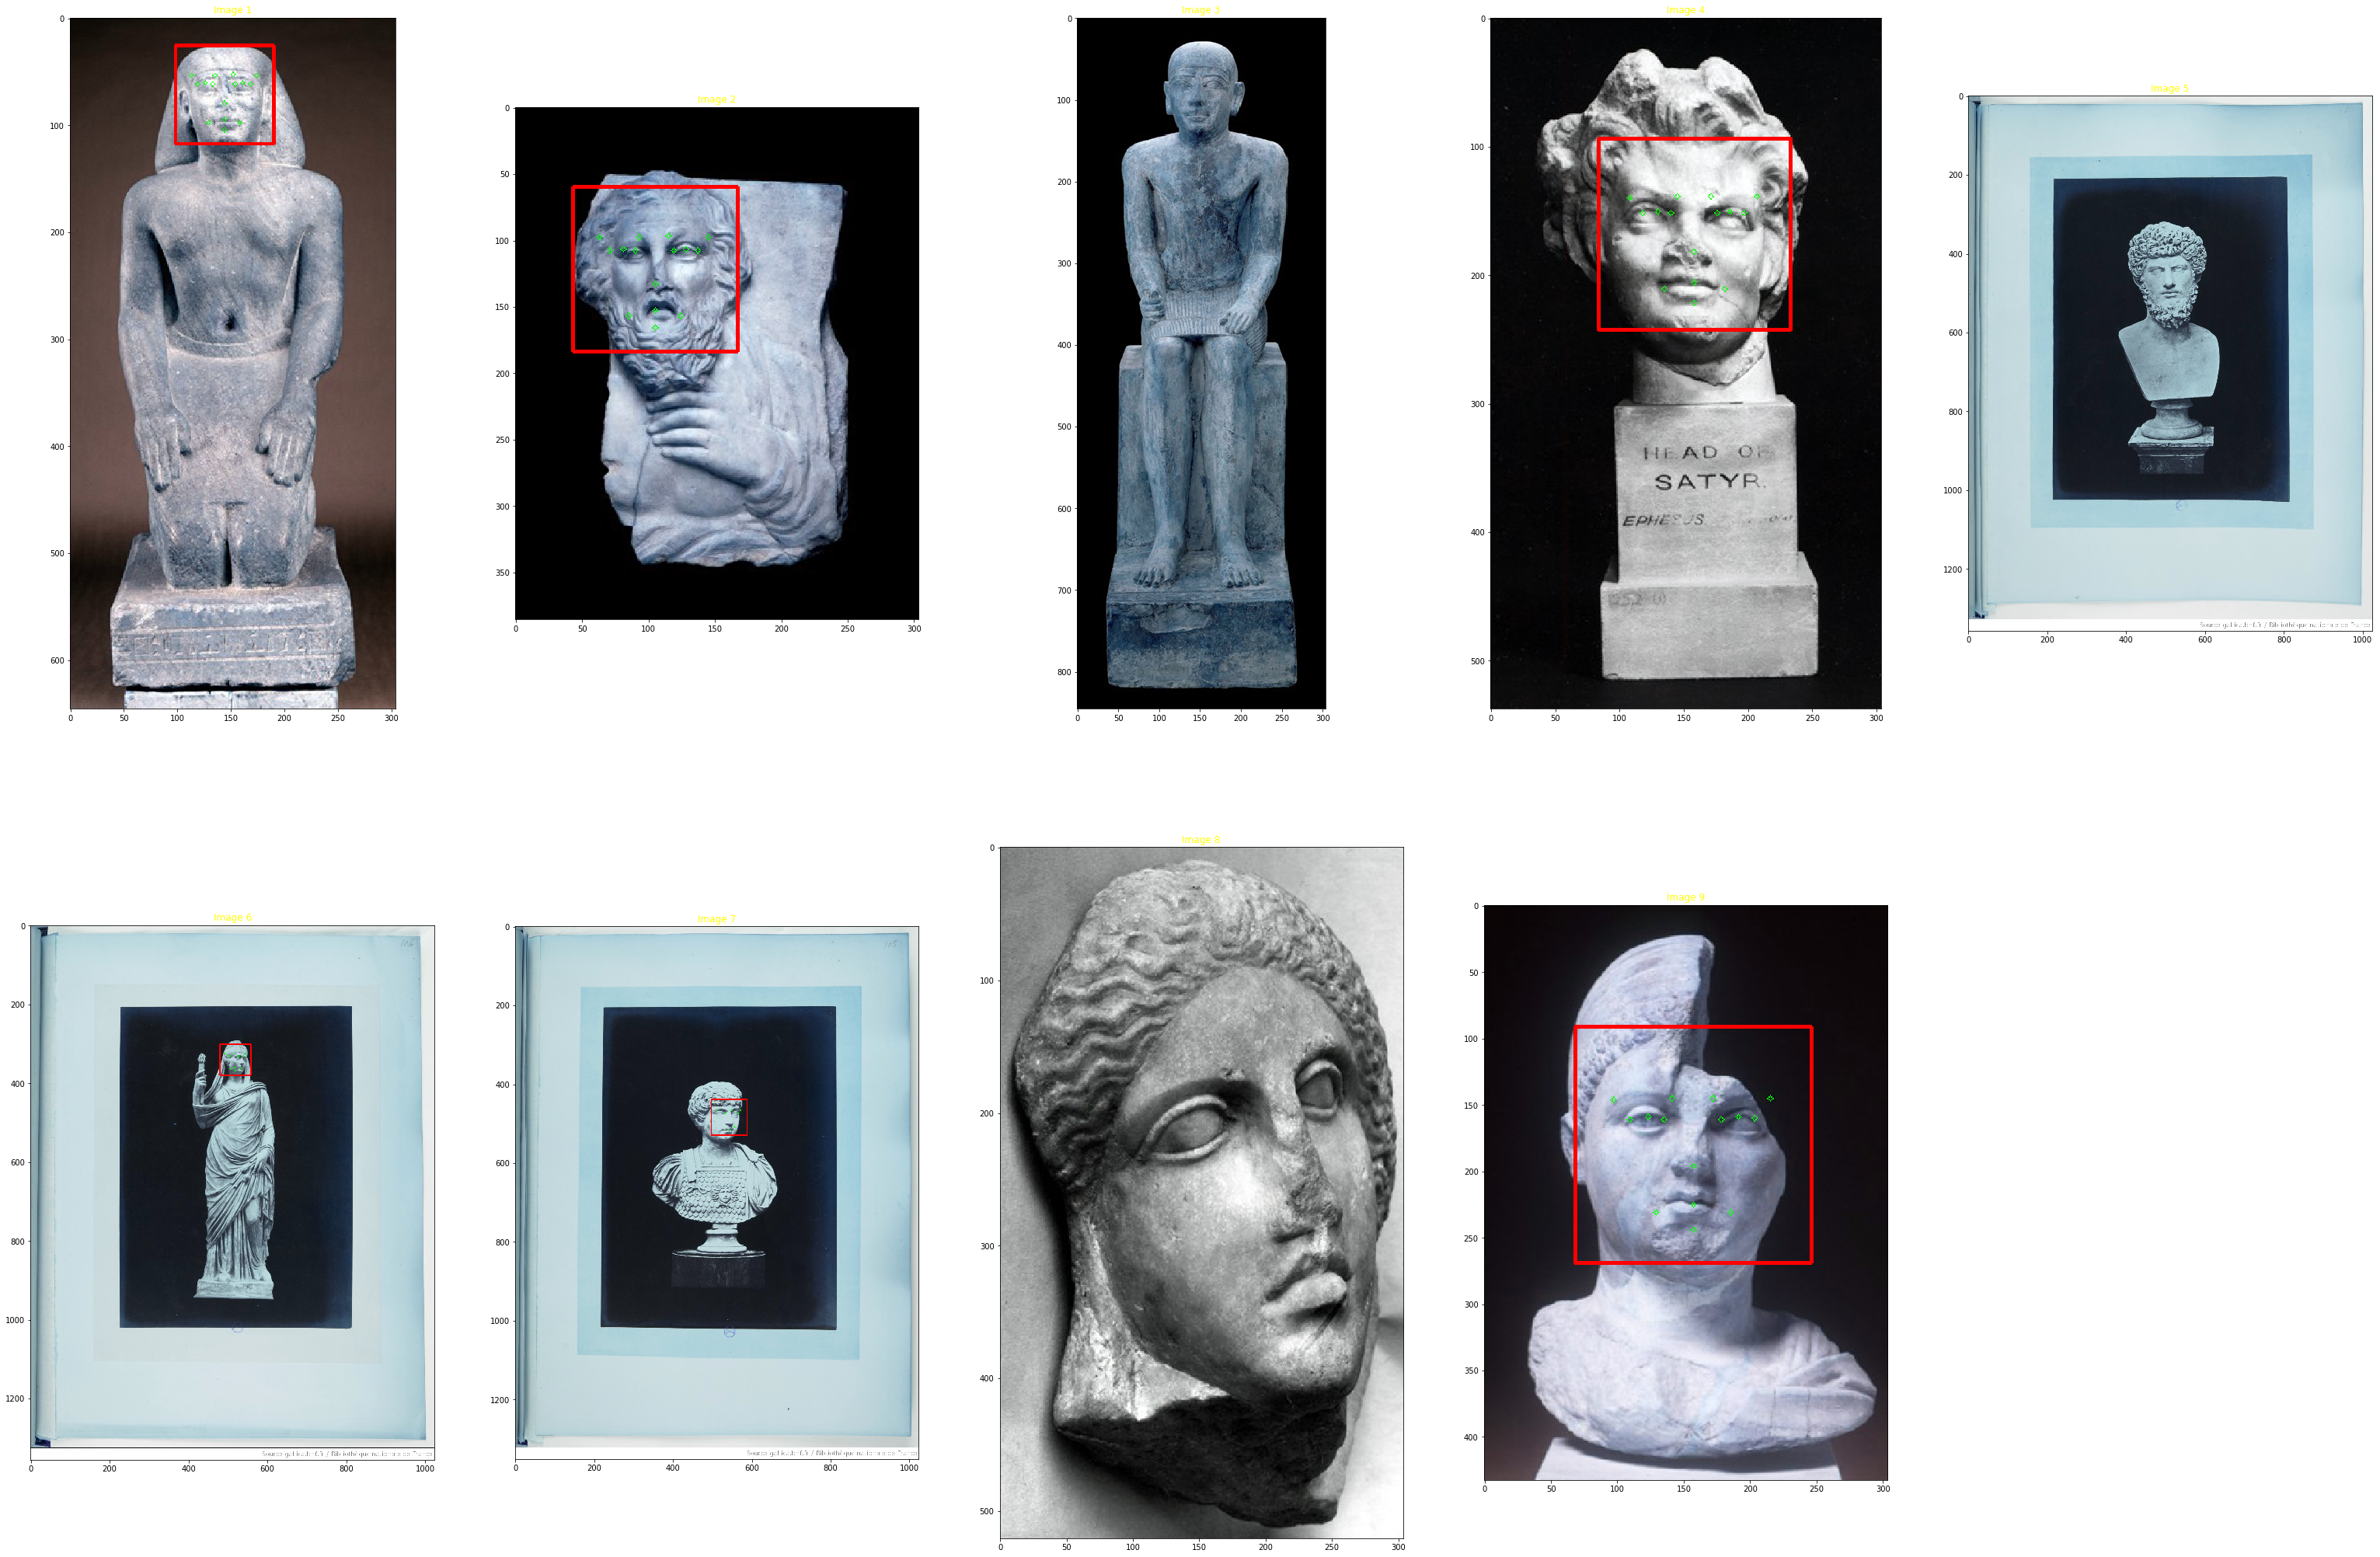

In [9]:
show_images(detected_images, cols=2)